In [18]:
# Imports and Setup
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import cv2
from tensorflow.keras.models import load_model
import albumentations as A
from tensorflow.keras.applications.resnet50 import preprocess_input
%matplotlib inline

# Configuration
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 416, 416, 3  # YOLO standard size
BATCH_SIZE = 16
NUM_CLASSES = 15  # Adjust based on your dataset

In [19]:
# Updated Data Preprocessing
def parse_annotation_file(image_path_str):
    """Parse annotation files and return bounding boxes and class labels."""
    
    # Extract the filename from the image path
    image_filename = os.path.basename(image_path_str)
    
    # Create path to the annotation file in the annotations folder
    base_dir = os.path.dirname(os.path.dirname(image_path_str))  # Go up one level from images
    annotation_path = os.path.join(base_dir, 'annotations', image_filename.replace('.jpg', '.txt'))
    
    print(f"Reading annotation from {annotation_path}")
    
    # Add file existence check
    if not os.path.exists(annotation_path):
        print(f"WARNING: Annotation file not found: {annotation_path}")
        return [0.0, 0.0, 0.0, 0.0], 0
        
    boxes = []
    classes = []
    try:
        with open(annotation_path, 'r') as f:
            for line in f:
                parts = line.strip().split(',')
                if len(parts) < 6:
                    continue
                x = float(parts[0])
                y = float(parts[1])
                w = float(parts[2])
                h = float(parts[3])
                cls = int(parts[5])  # Class ID is in the 6th position (index 5)
                boxes.append([x, y, w, h])
                classes.append(cls)
    except FileNotFoundError:
        return [0.0, 0.0, 0.0, 0.0], 0

    if len(boxes) == 0:
        return [0.0, 0.0, 0.0, 0.0], 0
        
    # Select the bounding box with the largest area
    areas = [box[2] * box[3] for box in boxes]
    max_idx = np.argmax(areas)
    best_box = boxes[max_idx]
    best_class = classes[max_idx]
    
    # Convert to normalized coordinates
    xmin = best_box[0] / IMG_WIDTH
    ymin = best_box[1] / IMG_HEIGHT
    xmax = (best_box[0] + best_box[2]) / IMG_WIDTH
    ymax = (best_box[1] + best_box[3]) / IMG_HEIGHT
    
    return [ymin, xmin, ymax, xmax], best_class
    
def load_and_preprocess_image_and_annotation(image_path):
    image_path_str = image_path.numpy().decode('utf-8')
    
    # Load and preprocess image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = preprocess_input(img)  # Use ResNet's preprocessing
    
    # For classification, create one-hot encoded labels
    _, class_id = parse_annotation_file(image_path_str)
    
    # Create one-hot encoded label
    # Assuming NUM_CLASSES = 2 as per your configuration
    label = tf.one_hot(class_id, depth=NUM_CLASSES)
    
    return img, label

def create_dataset(image_paths, batch_size=16):
    
    # Count class distribution first
    class_counts = {}
    for path in image_paths:
        _, class_id = parse_annotation_file(path)
        if class_id not in class_counts:
            class_counts[class_id] = 0
        class_counts[class_id] += 1
    
    print(f"Class distribution: {class_counts}")
    
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(
        lambda x: tf.py_function(
            load_and_preprocess_image_and_annotation,
            [x],
            [tf.float32, tf.float32]
        ),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    # Set output shapes explicitly
    # Set output shapes explicitly
    dataset = dataset.map(
        lambda x, y: (
            tf.ensure_shape(x, [224, 224, 3]), 
            tf.ensure_shape(y, [NUM_CLASSES])  # This should match NUM_CLASSES
        )
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [20]:
def create_resnet_model(input_shape=(224, 224, 3), num_classes=15):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze early layers but unfreeze later ones
    for layer in base_model.layers[:-2]:  # Unfreeze the last 20 layers
        layer.trainable = False

    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [21]:
# YOLOv3 Model Implementation
def create_yolo_model():
    """Create a YOLOv3 model."""
    # Define the input layer
    input_layer = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    # Darknet-53 backbone
    x = layers.Conv2D(32, (3, 3), padding='same', use_bias=False)(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    
    # Output layers
    bbox_output = layers.Conv2D(4, (1, 1), activation='sigmoid', name='bbox_output')(x)
    class_output = layers.Conv2D(NUM_CLASSES, (1, 1), activation='softmax', name='class_output')(x)
    
    # Create model
    model = Model(inputs=input_layer, outputs=[bbox_output, class_output])
    model.compile(
        optimizer='adam',
        loss={
            'bbox_output': 'mean_squared_error',
            'class_output': 'categorical_crossentropy'
        },
        metrics={
            'class_output': 'accuracy'
        }
    )
    return model


In [7]:
def train_models(image_paths, validation_split=0.2):
    # Split data
    train_paths, val_paths = train_test_split(image_paths, test_size=validation_split)
    
    # Create datasets
    train_dataset = create_dataset(train_paths)
    val_dataset = create_dataset(val_paths)
    
    # Create and compile models
    resnet_model = create_resnet_model()
    
    # Create callbacks
    callbacks = [
        ModelCheckpoint('best_resnet_model.keras', save_best_only=True, monitor='val_loss'),
        EarlyStopping(monitor='val_loss', patience=5),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
    ]
    
    # Train ResNet
    print("Training ResNet model...")
    resnet_history = resnet_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=20,
        callbacks=callbacks
    )
    
    return resnet_model, resnet_history

In [22]:
def plot_training_history(resnet_history):
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(resnet_history.history['accuracy'], label='ResNet Train')
    plt.plot(resnet_history.history['val_accuracy'], label='ResNet Val')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(resnet_history.history['loss'], label='ResNet Train')
    plt.plot(resnet_history.history['val_loss'], label='ResNet Val')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Files in images directory: ['9999979_00000_d_0000048.jpg', '0000272_03500_d_0000008.jpg', '9999952_00000_d_0000126.jpg', '9999938_00000_d_0000174.jpg', '9999938_00000_d_0000160.jpg', '9999952_00000_d_0000132.jpg', '9999938_00000_d_0000148.jpg', '9999941_00000_d_0000024.jpg', '9999941_00000_d_0000030.jpg', '0000006_06773_d_0000018.jpg', '9999938_00000_d_0000389.jpg', '9999973_00000_d_0000002.jpg', '9999941_00000_d_0000018.jpg', '9999973_00000_d_0000016.jpg', '0000278_02351_d_0000002.jpg', '0000365_00500_d_0000224.jpg', '9999938_00000_d_0000376.jpg', '9999952_00000_d_0000324.jpg', '9999938_00000_d_0000410.jpg', '0000320_04375_d_0000014.jpg', '9999938_00000_d_0000404.jpg', '9999980_00000_d_0000002.jpg', '9999952_00000_d_0000330.jpg', '9999938_00000_d_0000362.jpg', '9999952_00000_d_0000318.jpg', '9999938_00000_d_0000438.jpg', '9999971_00000_d_0000001.jpg', '9999952_00000_d_0000293.jpg', '9999952_00000_d_0000287.jpg', '0000369_00500_d_0000242.jpg', '0000078_03171_d_0000009.jpg', '9999976_00

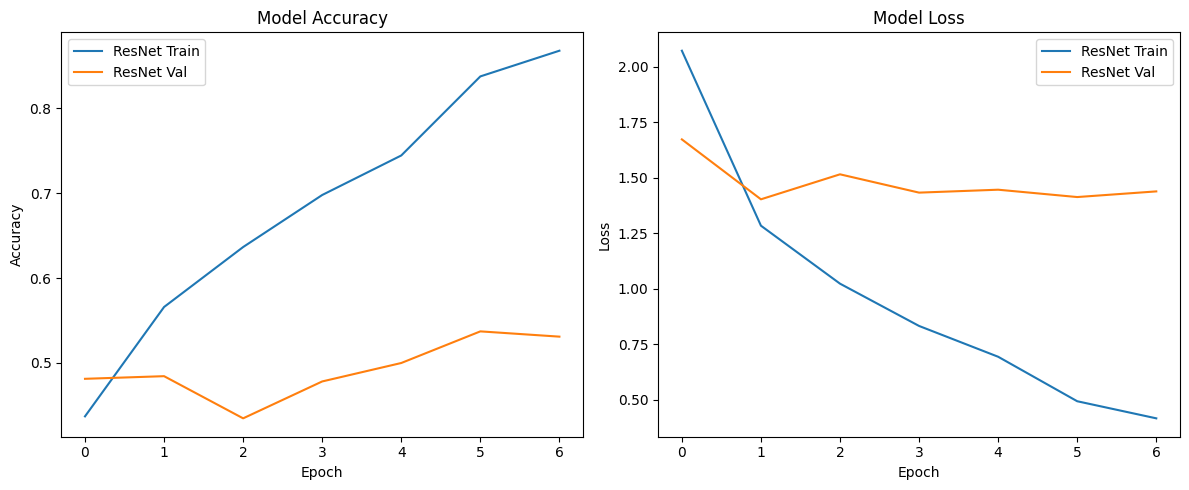

In [23]:
import os
from sklearn.model_selection import train_test_split

# Set the correct path where your dataset is located
base_dir = '/Users/stevenkliao/Desktop/2025 Spring/CSC675/Project 3/VisDrone2019-DET-test-dev'
# Since images are in the 'images' subfolder, update accordingly:
images_folder = os.path.join(base_dir, 'images')

# Debug: Print all files in the images directory
file_list = os.listdir(images_folder)
print("Files in images directory:", file_list)

# Get list of image paths (handling both .jpg and .png, case-insensitively)
image_paths = [
    os.path.join(images_folder, f) 
    for f in os.listdir(images_folder)
    if f.lower().endswith(('.jpg', '.png'))
]

print(f"Number of image files found: {len(image_paths)}")
if len(image_paths) == 0:
    raise ValueError(f"No image files were found in the directory: {images_folder}")

# Assuming your train_models function splits the data using train_test_split
resnet_model, resnet_history = train_models(image_paths)
plot_training_history(resnet_history)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model

def visualize_feature_maps(resnet_model, img_path, layer_names=None, image_size=(224, 224), max_channels=8):
    """
    Visualize the feature maps for the specified layers of a ResNet model.
    
    Args:
        resnet_model (tf.keras.Model): The trained or pre-trained ResNet model.
        img_path (str): Path to the image you want to visualize.
        layer_names (list of str): List of layer names for which to visualize the feature maps.
                                   If None, a few typical ResNet layer names are used as examples.
        image_size (tuple): Target size for the input image (e.g., (224, 224)).
        max_channels (int): Maximum number of channels to display per layer feature map. 
                            Set to None to display all channels.
    """
    # If layer_names is None, pick some typical ResNet layers to show as an example.
    if layer_names is None:
        # Common layer names in ResNet50 you might want to visualize:
        layer_names = [
            'conv1_conv',         # The very first Conv layer after input
            'conv2_block3_out',   # The output of the first ResNet block
            'conv3_block4_out',   # The output of the second ResNet block
            'conv4_block6_out',   # The output of the third ResNet block
            'conv5_block3_out'    # The output of the final ResNet block (before avg pool)
        ]
    
    # Create a sub-model to output feature maps at the desired layers
    outputs = [resnet_model.get_layer(name).output for name in layer_names]
    feature_map_model = Model(inputs=resnet_model.input, outputs=outputs)
    
    # Load, resize, and preprocess the image
    img = load_img(img_path, target_size=image_size)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)  # For ResNet50

    # Generate feature maps
    feature_maps = feature_map_model.predict(x)

    # For each requested layer, plot its feature maps
    for layer_name, fm in zip(layer_names, feature_maps):
        # fm shape: (batch, height, width, channels)
        print(f"Feature map shape for layer '{layer_name}': {fm.shape}")
        
        # Number of channels in this layer's feature map
        num_channels = fm.shape[-1]
        if max_channels is not None:
            num_channels_to_show = min(num_channels, max_channels)
        else:
            num_channels_to_show = num_channels

        # Arrange subplots
        cols = 4  # adjust if needed
        rows = int(np.ceil(num_channels_to_show / cols))
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
        fig.suptitle(f"Feature Maps - {layer_name}", fontsize=14)

        # If there's only one row, make axes iterable
        if rows == 1:
            axes = np.array([axes]).reshape(1, -1)

        # Plot each channel’s feature map
        channel_idx = 0
        for r in range(rows):
            for c in range(cols):
                if channel_idx < num_channels_to_show:
                    # Extract the channel
                    channel_img = fm[0, :, :, channel_idx]
                    axes[r, c].imshow(channel_img, cmap='viridis')
                    axes[r, c].axis('off')
                    axes[r, c].set_title(f"Channel {channel_idx}")
                    channel_idx += 1
                else:
                    # Hide any extra subplots
                    axes[r, c].axis('off')
        
        plt.tight_layout()
        plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
Feature map shape for layer 'conv1_conv': (1, 112, 112, 64)


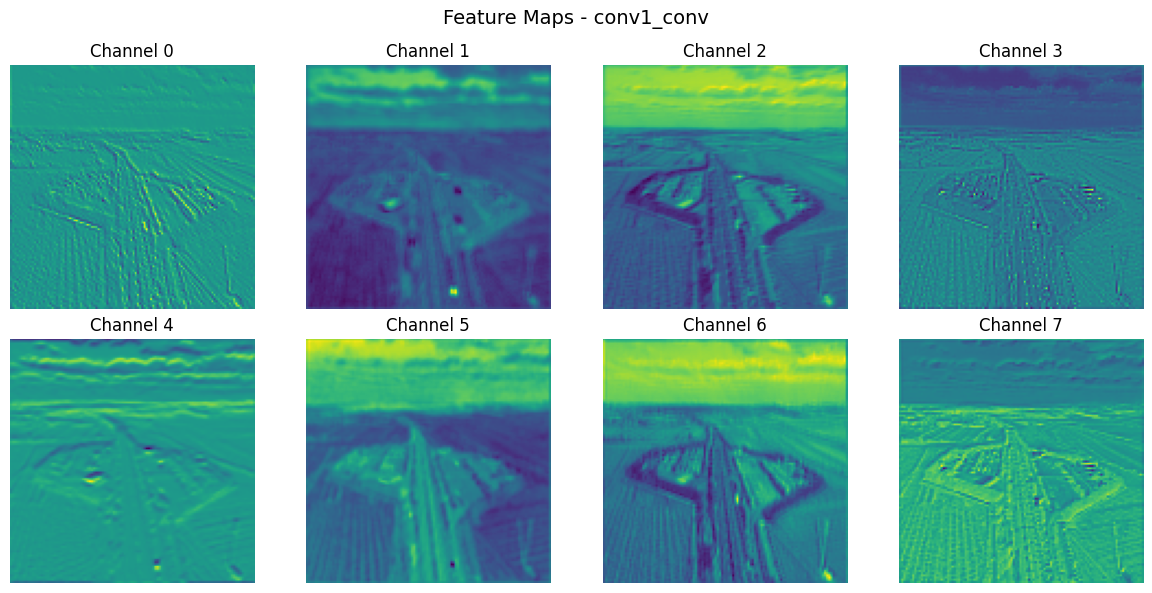

Feature map shape for layer 'conv2_block3_out': (1, 56, 56, 256)


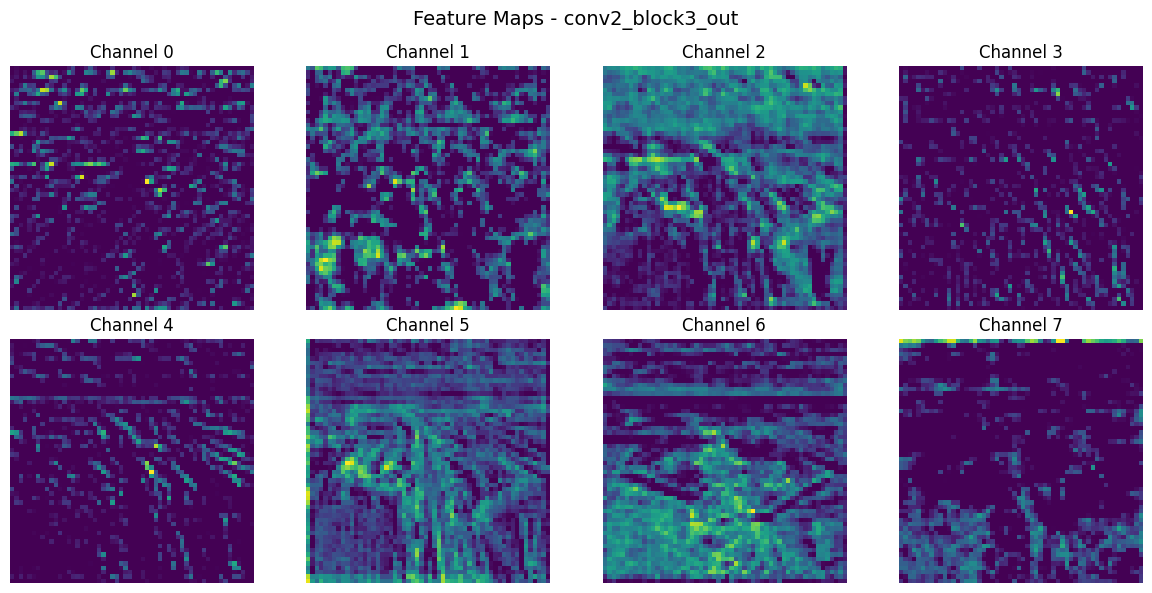

Feature map shape for layer 'conv3_block4_out': (1, 28, 28, 512)


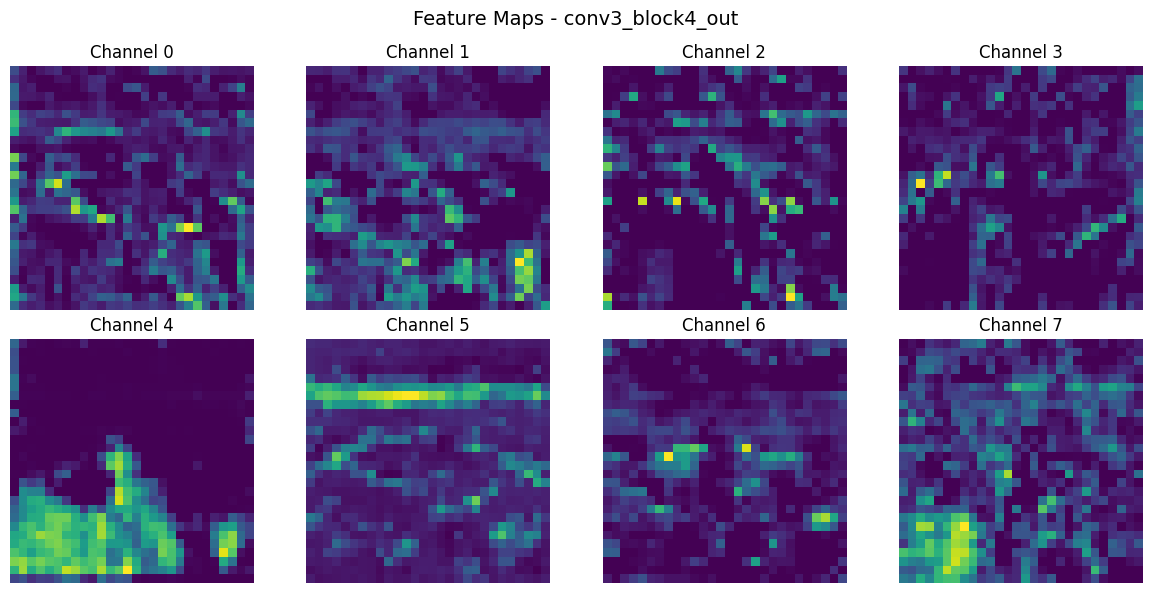

Feature map shape for layer 'conv4_block6_out': (1, 14, 14, 1024)


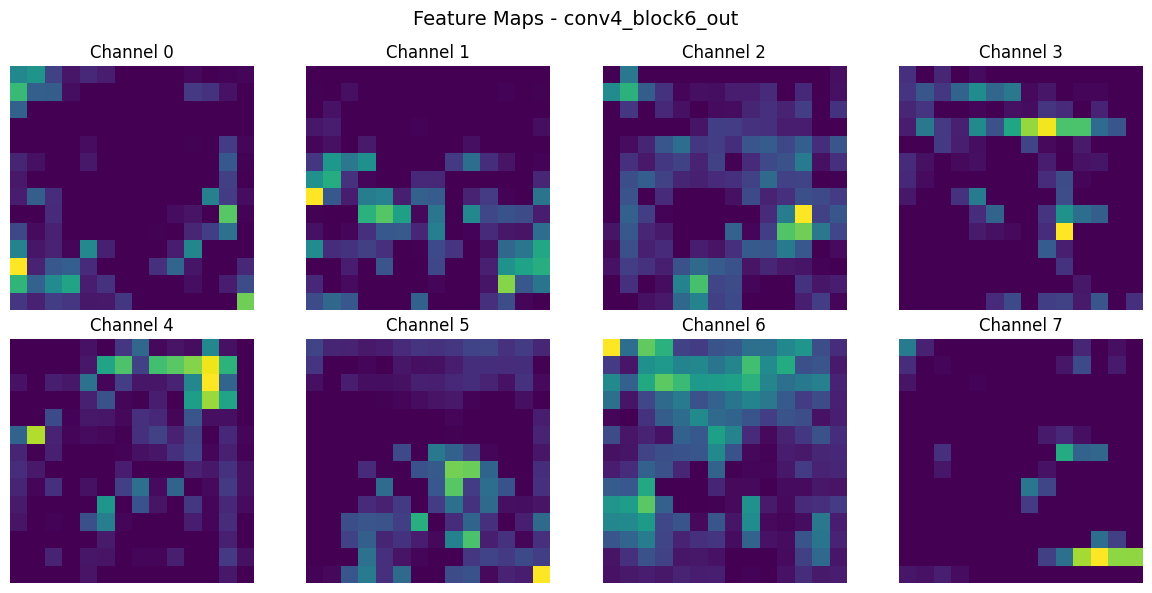

Feature map shape for layer 'conv5_block3_out': (1, 7, 7, 2048)


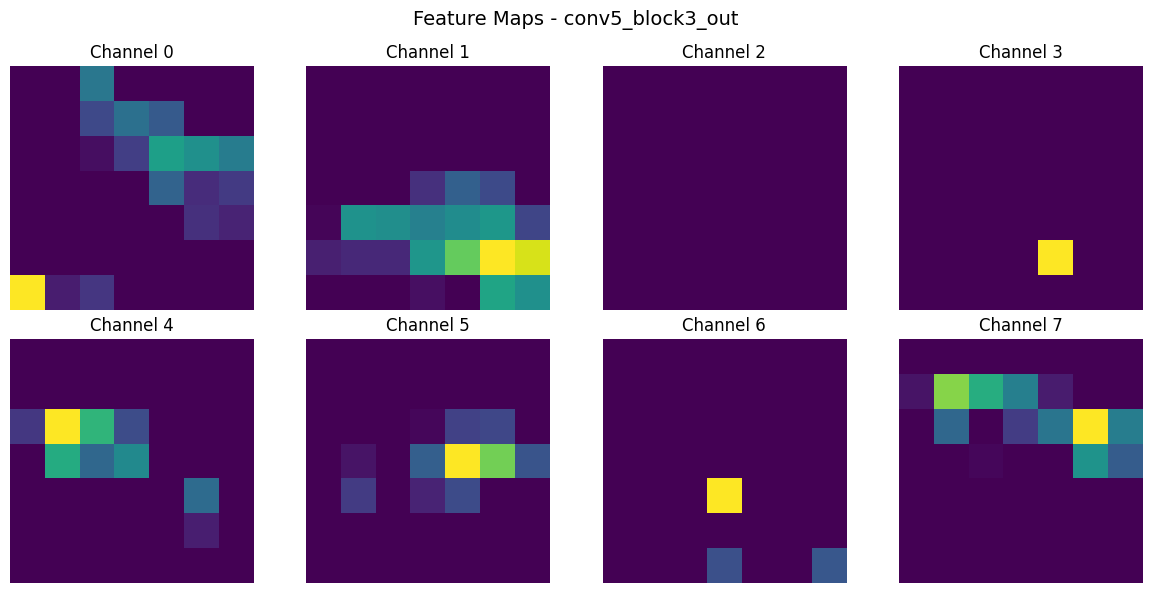

In [26]:
# Example usage: Visualize feature maps for a specific image

# Path to the target image
img_path = '/Users/stevenkliao/Desktop/2025 Spring/CSC675/Project 3/VisDrone2019-DET-test-dev/images/9999944_00000_d_0000002.jpg'

# Optionally, specify the layer names you want to inspect; if omitted, the function defaults will be used.
layer_names = [
    'conv1_conv',         # Example: first convolutional layer output
    'conv2_block3_out',   # Example: output from the first residual block
    'conv3_block4_out',   # Example: output from the second residual block
    'conv4_block6_out',   # Example: output from the third residual block
    'conv5_block3_out'    # Example: output from the final residual block (before pooling)
]

# Call the function to visualize the feature maps
# (Ensure that `resnet_model` is your instantiated and possibly pre-trained/loaded ResNet model)
visualize_feature_maps(
    resnet_model,
    img_path=img_path,
    layer_names=layer_names,
    image_size=(224, 224),  # ensure this matches your model's expected input size
    max_channels=8          # change this if you want to see more or fewer channels per layer
)